In [19]:
# !pip install numpy==1.19.5
import tensorflow as tf
import numpy as np
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [21]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [22]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Corn Disease",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3852 files belonging to 4 classes.


In [23]:
class_names = dataset.class_names
class_names

['Corn___Common_Rust',
 'Corn___Gray_Leaf_Spot',
 'Corn___Healthy',
 'Corn___Northern_Leaf_Blight']

In [24]:
len(dataset)

121

In [25]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 2 3 0 3 3 3 3 2 3 0 0 3 0 0 3 2 1 2 0 2 2 1 3 3 2 2 0 0 0 3]


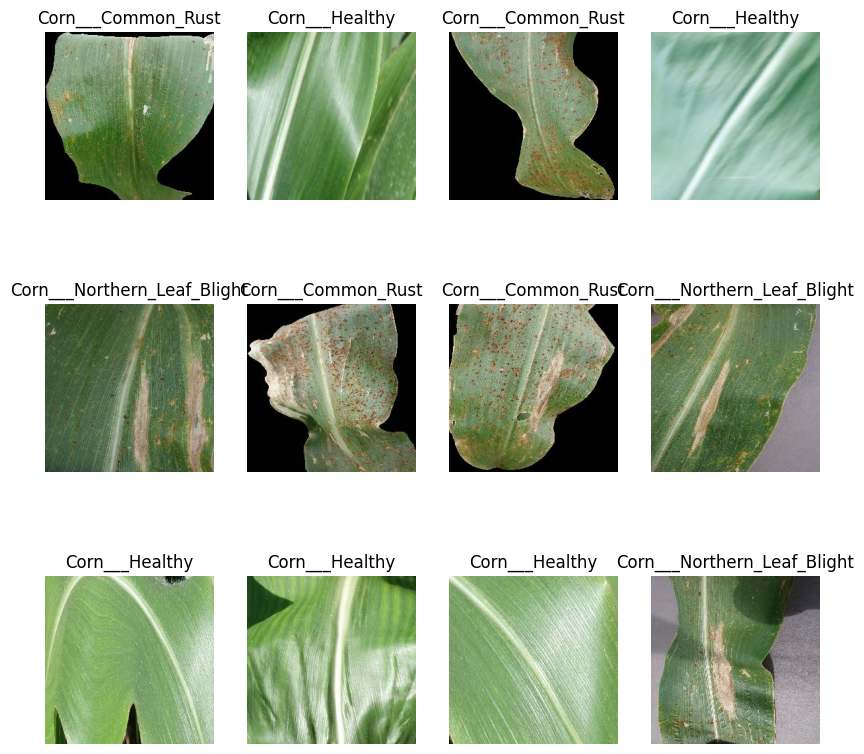

In [26]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [27]:
train_size = 0.8
len(dataset)*train_size

96.80000000000001

In [28]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [29]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [30]:
len(train_ds)

96

In [31]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255),
])


In [33]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [34]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [35]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [36]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [37]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [38]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
96/96 [==============================] - 52s 342ms/step - loss: 0.6639 - accuracy: 0.7090 - val_loss: 0.4935 - val_accuracy: 0.8203
Epoch 2/50
96/96 [==============================] - 22s 224ms/step - loss: 0.3282 - accuracy: 0.8663 - val_loss: 0.3380 - val_accuracy: 0.8802
Epoch 3/50
96/96 [==============================] - 22s 229ms/step - loss: 0.2793 - accuracy: 0.8811 - val_loss: 0.2413 - val_accuracy: 0.9010
Epoch 4/50
96/96 [==============================] - 23s 238ms/step - loss: 0.2366 - accuracy: 0.8899 - val_loss: 0.5937 - val_accuracy: 0.8047
Epoch 5/50
96/96 [==============================] - 22s 232ms/step - loss: 0.2846 - accuracy: 0.8742 - val_loss: 0.2244 - val_accuracy: 0.9062
Epoch 6/50
96/96 [==============================] - 22s 233ms/step - loss: 0.2143 - accuracy: 0.8968 - val_loss: 0.1676 - val_accuracy: 0.9297
Epoch 7/50
96/96 [==============================] - 22s 233ms/step - loss: 0.2269 - accuracy: 0.8974 - val_loss: 0.2201 - val_accuracy: 0.8932

In [39]:
scores = model.evaluate(test_ds)

13/13 [==============================] - 3s 43ms/step - loss: 0.0674 - accuracy: 0.9760


In [40]:
scores

[0.06742200255393982, 0.9759615659713745]

In [41]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [43]:
# plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        # ax = plt.subplot(3, 3, i + 1)
        # plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        # plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        # plt.axis("off")
        print(f"actual_class {actual_class}, predicted_class {predicted_class}, confidence {confidence}")

1/1 [==============================] - 1s 956ms/step
actual_class Corn___Healthy, predicted_class Corn___Healthy, confidence 99.99
1/1 [==============================] - 0s 31ms/step
actual_class Corn___Healthy, predicted_class Corn___Healthy, confidence 99.99
1/1 [==============================] - 0s 35ms/step
actual_class Corn___Healthy, predicted_class Corn___Healthy, confidence 99.97
1/1 [==============================] - 0s 38ms/step
actual_class Corn___Healthy, predicted_class Corn___Healthy, confidence 99.96
1/1 [==============================] - 0s 34ms/step
actual_class Corn___Common_Rust, predicted_class Corn___Common_Rust, confidence 100.0
1/1 [==============================] - 0s 36ms/step
actual_class Corn___Northern_Leaf_Blight, predicted_class Corn___Northern_Leaf_Blight, confidence 100.0
1/1 [==============================] - 0s 30ms/step
actual_class Corn___Healthy, predicted_class Corn___Healthy, confidence 99.79
1/1 [==============================] - 0s 39ms/step
act

In [45]:
model.save("./corn.h5")